## Notes
* Can run Machi on the large concatenated cube instead of each imgage before concatenating.
* save the the cm and saturation array as a file and load it instead of running the function again.
* Setting neighbor weight takes a lot of RAM (24GB)
* Endmember count does not affect ram usage
* reducing endmember by half sped up calculations by 50%
* 10 images, 16 endmembers and 10 runs took 60 minutes for one equlibiration
* 10 images, 8 endmembers and 10 runs took 45 minutes for one equlibiration
* sparsity sweep takes a lot of time (200 to 300 minutes)
* 10 images, 8 endmembers and 10 runs took 700 min for full network

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from hypso import Hypso
sys.path.append(os.path.abspath("D:/Hierarchical Unmixing Label"))
import machi.base as ac

###  GB RAM Cost 
* running AI env              1.3GB --baseline
* +all imports                1.4GB (+0.1GB)
* +Functions                  1.5GB (+0.1GB)
* +hypso_Machi_Concatenate    11.5GB (+10GB)
* -2GB for the each hypso object
* +save the cm_combined and saturated_combined array to a file
* +Loading the cm_combined and saturated_combined array from a file (6.0GB)
* +Loading the cm_norm arrays (6.0GB)

In [10]:
#Functions
def plot_cm_rgb_composite(cm,title=""):
    cube=cm.reshape(-1,1092,112)
    #print("cm.shape: ",cm.shape)
    #print("cube.shape: ",cube.shape)

    rgb = np.zeros((cube.shape[0], cube.shape[1], 3))
    rgb[:,:,0] = cube[:,:,69]
    rgb[:,:,1] = cube[:,:,46]
    rgb[:,:,2] = cube[:,:,26]
    rgb*=1

    rgb[rgb>1] =1
    rgb[np.isnan(rgb)]=1
    rgb_image = np.rot90(rgb)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    if title!="":
        plt.title(title)
    plt.imshow(rgb_image, aspect=0.1)

    return rgb_image

def create_rgb_composite_from_satobj(satobj, red_band_index=69, green_band_index=46, blue_band_index=26):
    """
    Create an RGB composite image from a satellite object (satobj).

    Parameters:
    - satobj: An instance of the satellite object containing the image data.
    - red_band_index: The index of the band to use for the red channel.
    - green_band_index: The index of the band to use for the green channel.
    - blue_band_index: The index of the band to use for the blue channel.

    Returns:
    - rgb_image: A 3D numpy array representing the RGB composite image.
    """
    # Get the data cube from the satellite object
    data_cube = satobj.l1b_cube  # Assuming this is a 3D array (width, height, bands)
    # Extract the specified bands for RGB channels
    red_band = data_cube[:, :, red_band_index]
    green_band = data_cube[:, :, green_band_index]
    blue_band = data_cube[:, :, blue_band_index]

    # Stack the bands to create an RGB image
    rgb_image = np.stack((red_band, green_band, blue_band), axis=-1)

    # Normalize the RGB image to the range [0, 255] for visualization
    rgb_image = np.clip(rgb_image, 0, np.max(rgb_image))  # Clip values to avoid overflow
    rgb_image = (rgb_image / np.max(rgb_image) * 255).astype(np.uint8)  # Scale to [0, 255]

    flipped_rotated_image = np.fliplr(np.rot90(rgb_image))
    plt.imshow(flipped_rotated_image, aspect=0.1, vmin=0, vmax=1, interpolation='nearest')  # Rotate and flip to correct orientation
    plt.title("RGB: "+str(satobj.hypso_path.stem))
    plt.axis('off')
    plt.show()

    return rgb_image

def plot_DEH_overlay(rgb_image, node, opacity=0.5, reverse=True):
    """
    Plot and return the overlay image of DEH figure on top of an RGB image with controllable opacity.

    Parameters:
    - rgb_image: The RGB image to overlay the DEH figure on, shape (w, h, 3).
    - deh_figure: The DEH figure to overlay, shape (w, h).
    - opacity: The opacity of the DEH figure (0.0 to 1.0).
    - reverse: If True, zero DEH values are red and non-zero DEH values are transparent.

    Returns:
    - overlay_image: The RGB image with the DEH figure overlaid, with areas where DEH is zero see-through.
    """

    deh_figure = dehf_load.nodes[node].map.reshape(dehf_load.plot_size)  
    # Normalize both the DEH figure and the RGB image to the range [0, 1]
    deh_figure_normalized = (deh_figure - np.min(deh_figure)) / (np.max(deh_figure) - np.min(deh_figure))
    rgb_image_normalized = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

    # Create a red overlay with the same shape as the DEH figure
    red_overlay = np.ones_like(deh_figure_normalized)[:, :, np.newaxis] * [1, 0, 0]  # Red color

    # Overlay the DEH figure on top of the RGB image with controllable opacity
    if reverse:
        overlay_image = rgb_image_normalized * (1 - opacity) + red_overlay * opacity * (1 - deh_figure_normalized[:, :, np.newaxis])
    else:
        overlay_image = rgb_image_normalized * (1 - opacity) + red_overlay * opacity * deh_figure_normalized[:, :, np.newaxis]

    # If opacity is 1, make the areas where DEH is zero not see-through
    if opacity == 1:
        overlay_image[deh_figure == 0] = rgb_image_normalized[deh_figure == 0]
    # If opacity is high, make the zero values in DEH not see-through, only the non-zero values should be visible
    elif opacity > 0.5:
        overlay_image[deh_figure == 0] = rgb_image_normalized[deh_figure == 0]
        overlay_image[deh_figure != 0] = overlay_image[deh_figure != 0] * opacity

    # Plot the overlay image
    # fig, axs = plt.subplots(1, 2, figsize=(50, 200))
    fig, axs = plt.subplots(1, 2, figsize=(50, 200), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
    axs[0].imshow(np.fliplr(np.rot90(overlay_image)), aspect=dehf_load.plot_aspect, vmin=0, vmax=1, interpolation='bicubic')
    axs[0].set_title("Node: "+node+" Opacity: "+str(opacity)+" Reverse: "+str(reverse))
    axs[0].axis('off')

    # Plot the reverse overlay image
    reverse_overlay_image = rgb_image_normalized * (1 - opacity) + red_overlay * opacity * deh_figure_normalized[:, :, np.newaxis]
    axs[1].imshow(np.fliplr(np.rot90(reverse_overlay_image)), aspect=dehf_load.plot_aspect, vmin=0, vmax=1, interpolation='bicubic')
    axs[1].set_title("Node: "+node+" Opacity: "+str(opacity)+" Reverse: "+str(not reverse))
    axs[1].axis('off')

    plt.show()

    return overlay_image

def hypso_Machi_Concatenate(hypso_file_path, cube_combined, saturated_combined, verbose=True):

    image_name = os.path.splitext(os.path.basename(hypso_file_path))[0]
    print(image_name)
    # load and calibrate the hypso image, e.g. convert to radiance
    satobj = Hypso(hypso_file_path)
    

    maxes = np.max(satobj.rawcube, axis = -1) #rawcube is not an attribute of the Hypso 2.0+ object  
    saturated = maxes > 35000
    cube=satobj.get_toa_reflectance()[:,:,6:118]
    c = cube.reshape(-1,112)
    if verbose:
        print("saturated.shape: ",saturated.shape)
        print("cube.shape: ",cube.shape)
        print("c.shape: ",c.shape)

    T, S, objs = ac.atm_correction(c, solar=np.ones(112), verbose=False, tol=0.01, est_min_R=0.05)
    wl = satobj.wavelengths[6:118]
    cube_norm = (cube - S) /T
    #cube_norm[saturated] = 1 #np.nan
    
    c_norm = cube_norm.reshape(-1,112)
    saturated_flat = saturated.reshape(-1)
    
    mins = [np.nanmin(c_norm[:,i]) for i in range(112)] #when saturation sets to nan, the min is not defined and the following line will set the min to nan
    cm_norm = c_norm - 0.95*np.array(mins)
    
    cm_combined = np.concatenate((cm_norm, cube_combined), axis=0)
    saturated_output = np.concatenate((saturated_flat, saturated_combined), axis=0)
    saturated_output = np.asarray(saturated_output, dtype=bool)
    if verbose:
        print("cube_norm.shape: ",cube_norm.shape)
        print("c_norm.shape: ",c_norm.shape)
        print("cm_norm.shape: ",cm_norm.shape)
        print("cm_combined.shape: ",cm_combined.shape)
        print("saturated_flat.shape: ",saturated_flat.shape)
        print("saturated_output.shape: ",saturated_output.shape)

    #Plot RGB composite
    rgb = np.zeros(cube_norm.shape[:2] + (3,))
    rgb[:,:,0] = cube_norm[:,:,69]
    rgb[:,:,1] = cube_norm[:,:,46]
    rgb[:,:,2] = cube_norm[:,:,26]
    rgb*=5

    rgb[rgb>1] =1
    rgb[np.isnan(rgb)]=1
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    plt.imshow(np.rot90(rgb), aspect=0.1)
    plt.savefig('D:\Hierarchical Unmixing Label\hUH\images\\'+image_name+'_rgb_composite.png')
    np.save('D:\Hierarchical Unmixing Label\hUH\images\\'+image_name+'_cm_norm.npy', cm_norm)

    return cm_combined, saturated_output, cm_norm, satobj


grizzlybay_2024-09-30T18-25-29Z-l1a
Processing *wide* Image with Dimensions: (598, 1092)
Radiometric Correction Ongoing
Smile Correction Ongoing
Destriping Correction Ongoing
L1b.nc file already exists. Not creating it.
Getting Projection Data without lat/lon correction =========================================
Generating Geotiff ************************************
  Projecting pixel geodetic to map ...
    [36.8222, 40.041054, -123.17953, -121.541954]
    using UTM map: WGS 84 / UTM zone 10N EPSG: 32610
    Area covered by image: 23294614181.474487 m^2 = 23294.614181474488 km^2
  Bounding boxes and resample grid ...
  Grid points inside bounding polygon ...
    Points inside boundary: 1281694 / 2762548
  Registration, aka rectification, aka resampling, aka gridding ...
      Starting band 11
      Starting band 61
      Starting band 50
      Starting band 31
      Done with band 31      Done with band 50

      Done with band 11
      Done with band 61
Done RGB/RGBA Geotiff
RGBA Tif

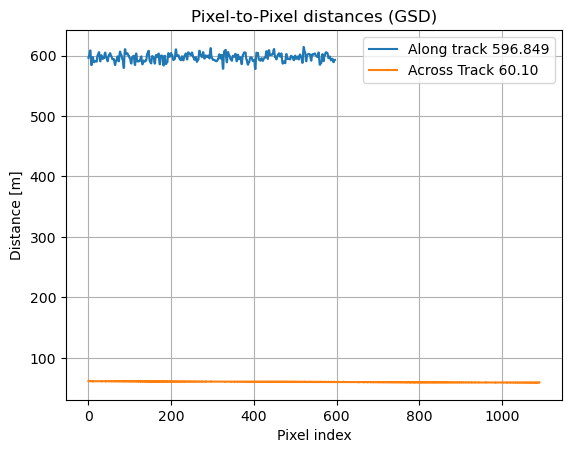

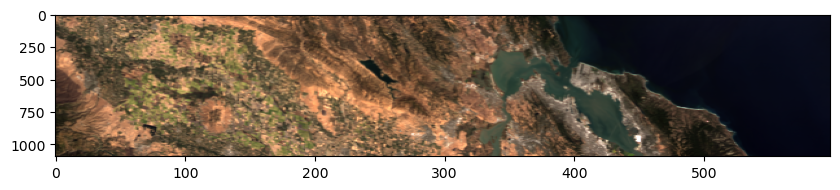

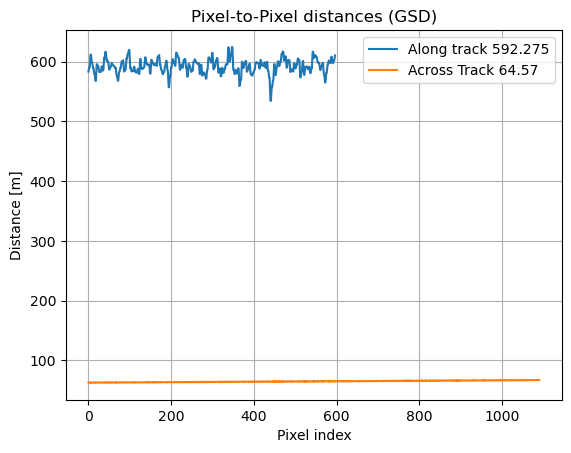

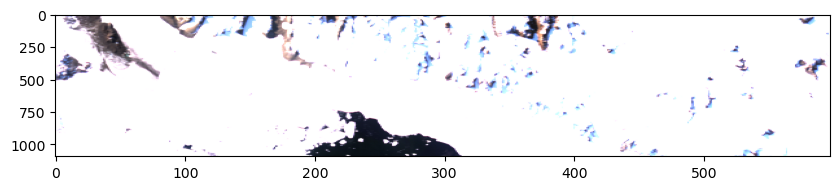

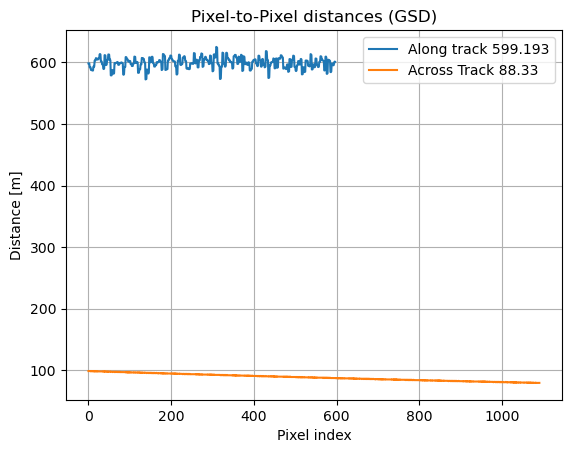

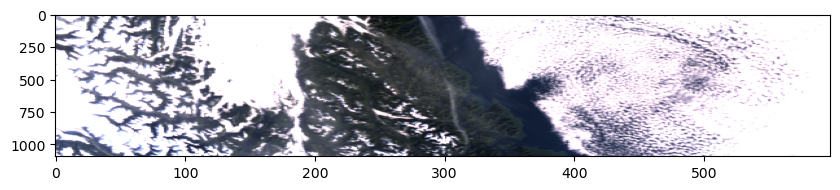

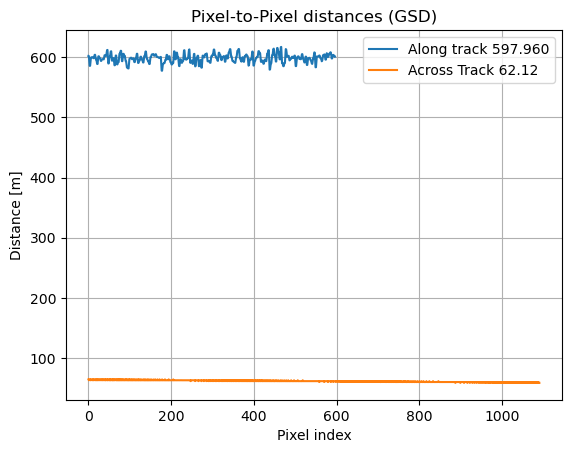

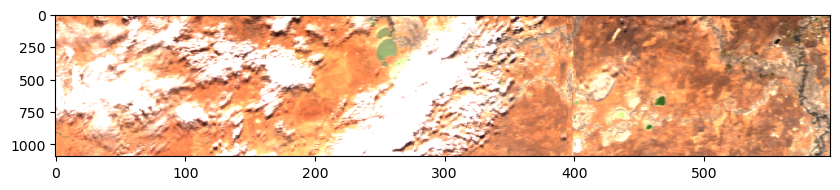

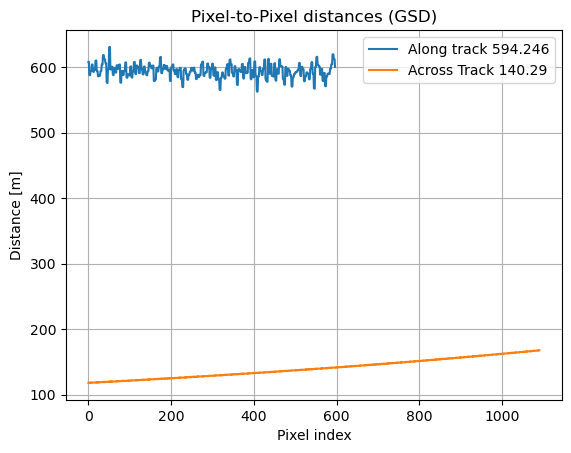

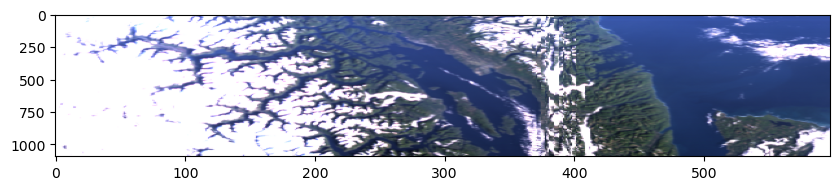

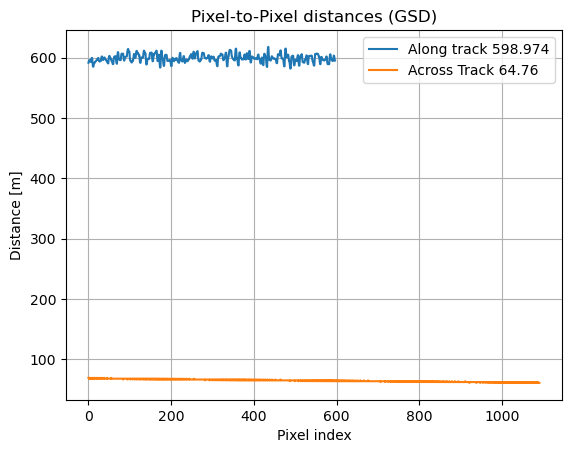

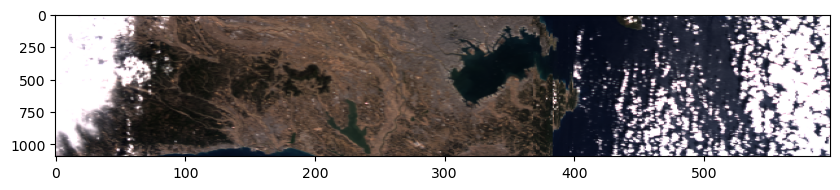

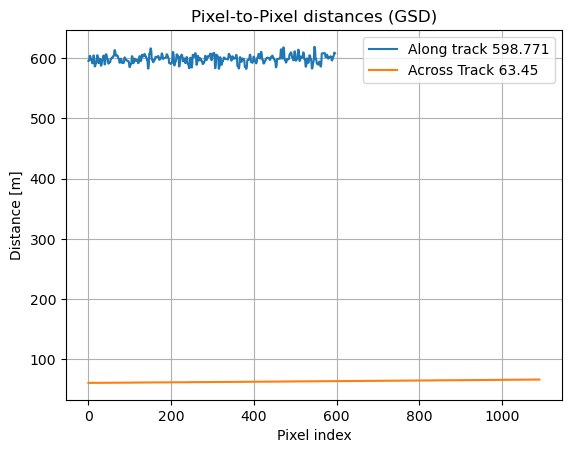

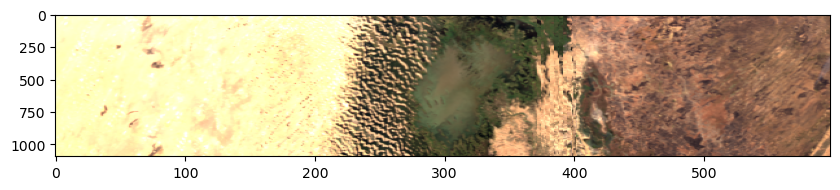

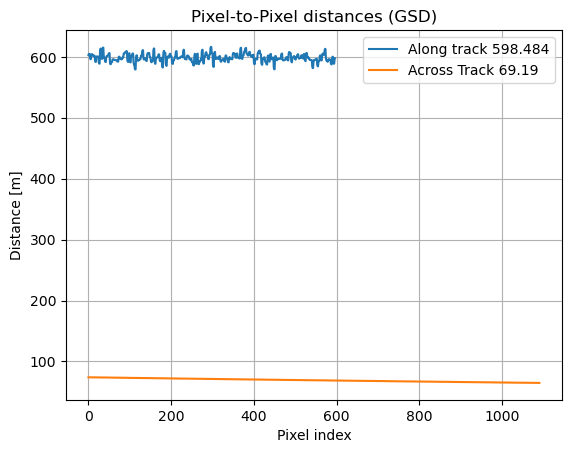

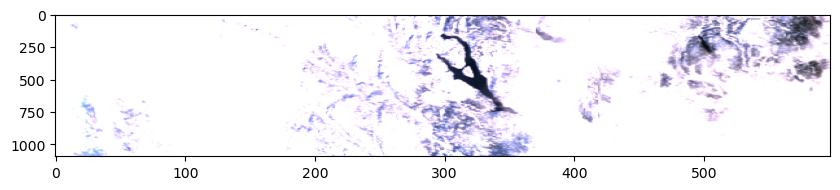

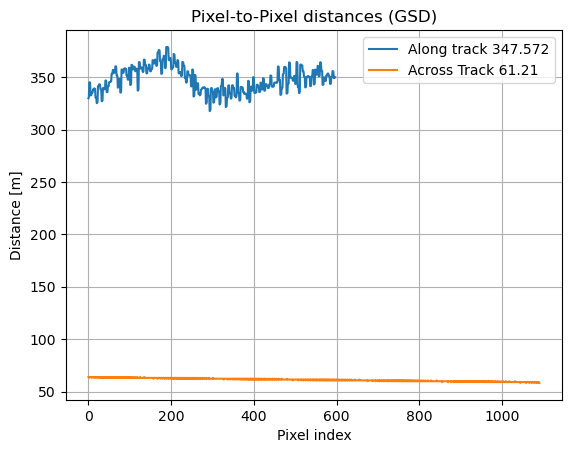

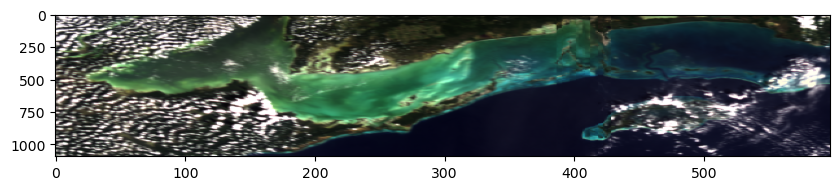

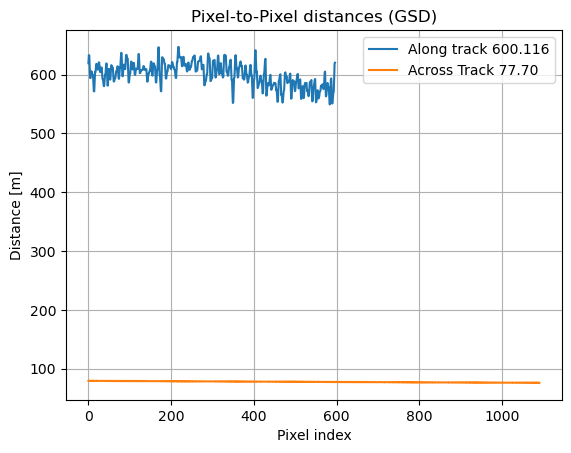

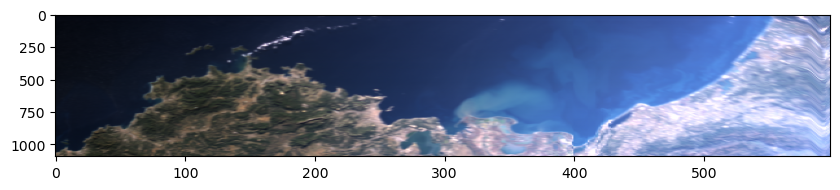

In [5]:
#Get the data, 10 images, 15 min
cm_combined= np.empty((0,112))
saturated_combined = np.empty(0)

cm_combined, saturated_combined, c_norm_grizzlybay,     satobj_grizzlybay,  =hypso_Machi_Concatenate(r"D:\Downloads\grizzlybay_2024-09-30T18-25-29Z-l1a.nc",    cm_combined, saturated_combined)
cm_combined, saturated_combined, c_norm_victoriaLand,   satobj_victoriaLand =hypso_Machi_Concatenate(r"D:\Downloads\victoriaLand_2025-01-03T13-05-25Z-l1a.nc",  cm_combined, saturated_combined)
cm_combined, saturated_combined, c_norm_catala,         satobj_catala       =hypso_Machi_Concatenate(r"D:\Downloads\catala_2025-01-28T19-17-32Z-l1a.nc",        cm_combined, saturated_combined)
cm_combined, saturated_combined, c_norm_menindee,       satobj_menindee     =hypso_Machi_Concatenate(r"D:\Downloads\menindee_2025-01-21T00-00-40Z-l1a.nc",      cm_combined, saturated_combined)
cm_combined, saturated_combined, c_norm_deepbay,        satobj_deepbay      =hypso_Machi_Concatenate(r"D:\Downloads\deepbay_2025-01-24T18-21-34Z-l1a.nc",       cm_combined, saturated_combined)
cm_combined, saturated_combined, c_norm_kemigawa,       satobj_kemigawa     =hypso_Machi_Concatenate(r"D:\Downloads\kemigawa_2025-01-30T01-03-42Z-l1a.nc",      cm_combined, saturated_combined)
cm_combined, saturated_combined, c_norm_chad,           satobj_chad         =hypso_Machi_Concatenate(r"D:\Downloads\chad_2025-01-30T08-58-47Z-l1a.nc",          cm_combined, saturated_combined)
cm_combined, saturated_combined, c_norm_mjosa,          satobj_mjosa        =hypso_Machi_Concatenate(r"D:\Downloads\mjosa_2025-01-30T10-19-48Z-l1a.nc",         cm_combined, saturated_combined)
cm_combined, saturated_combined, c_norm_chetumalbay,    satobj_chetumalbay  =hypso_Machi_Concatenate(r"D:\Downloads\chetumalbay_2025-01-17T16-01-46Z-l1a.nc",   cm_combined, saturated_combined)
cm_combined, saturated_combined, c_norm_lacrau,         satobj_lacrau       =hypso_Machi_Concatenate(r"D:\Downloads\lacrau_2025-01-17T09-40-10Z-l1a.nc",        cm_combined, saturated_combined)
# Save the arrays
np.save('D:\Hierarchical Unmixing Label\hUH\images\cm_combined_10.npy', cm_combined)
np.save('D:\Hierarchical Unmixing Label\hUH\images\saturated_combined_10.npy', saturated_combined)

In [2]:
#Load the combined arrays (6.0GB RAM)
cm_combined_loaded = np.load('D:\Hierarchical Unmixing Label\hUH\images\cm_combined_10.npy')
saturated_combined_loaded = np.load('D:\Hierarchical Unmixing Label\hUH\images\saturated_combined_10.npy')

In [3]:
#Load the cm_norm arrays (6.0GB RAM)
grizzlybay_cm_norm = np.load(r'D:\Hierarchical Unmixing Label\hUH\images\grizzlybay_2024-09-30T18-25-29Z-l1a_cm_norm.npy')
victoriaLand_cm_norm = np.load(r'D:\Hierarchical Unmixing Label\hUH\images\victoriaLand_2025-01-03T13-05-25Z-l1a_cm_norm.npy')
catala_cm_norm = np.load(r'D:\Hierarchical Unmixing Label\hUH\images\catala_2025-01-28T19-17-32Z-l1a_cm_norm.npy')
menindee_cm_norm = np.load(r'D:\Hierarchical Unmixing Label\hUH\images\menindee_2025-01-21T00-00-40Z-l1a_cm_norm.npy')
deepbay_cm_norm = np.load(r'D:\Hierarchical Unmixing Label\hUH\images\deepbay_2025-01-24T18-21-34Z-l1a_cm_norm.npy')
kemigawa_cm_norm = np.load(r'D:\Hierarchical Unmixing Label\hUH\images\kemigawa_2025-01-30T01-03-42Z-l1a_cm_norm.npy')
chad_cm_norm = np.load(r'D:\Hierarchical Unmixing Label\hUH\images\chad_2025-01-30T08-58-47Z-l1a_cm_norm.npy')
mjosa_cm_norm = np.load(r'D:\Hierarchical Unmixing Label\hUH\images\mjosa_2025-01-30T10-19-48Z-l1a_cm_norm.npy')
chetumalbay_cm_norm = np.load(r'D:\Hierarchical Unmixing Label\hUH\images\chetumalbay_2025-01-17T16-01-46Z-l1a_cm_norm.npy')
lacrau_cm_norm = np.load(r'D:\Hierarchical Unmixing Label\hUH\images\lacrau_2025-01-17T09-40-10Z-l1a_cm_norm.npy')


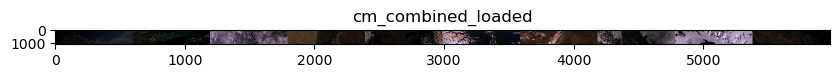

: 

In [ ]:
#Plot the rgb composite of the combined array
rgb_combined = plot_cm_rgb_composite(cm_combined_loaded, "cm_combined_loaded")

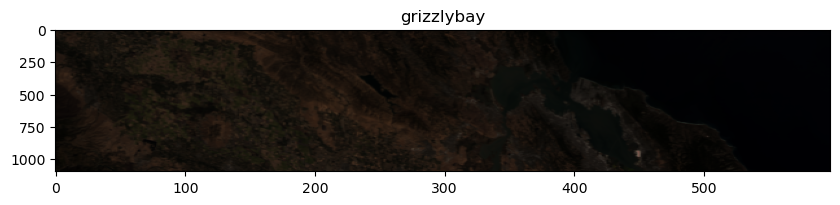

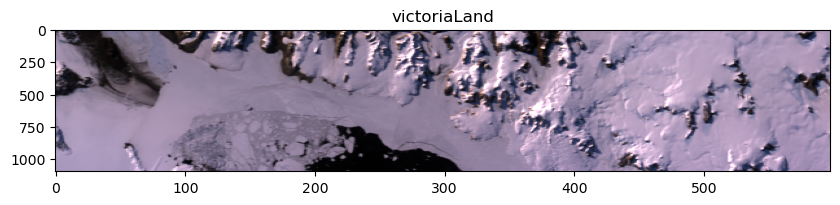

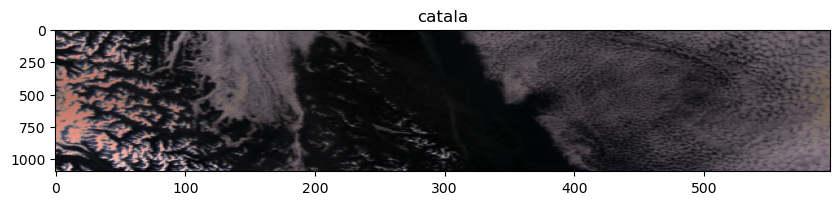

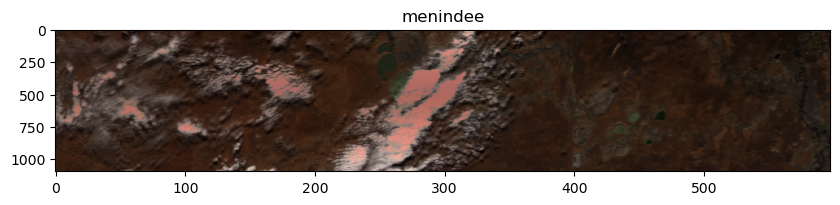

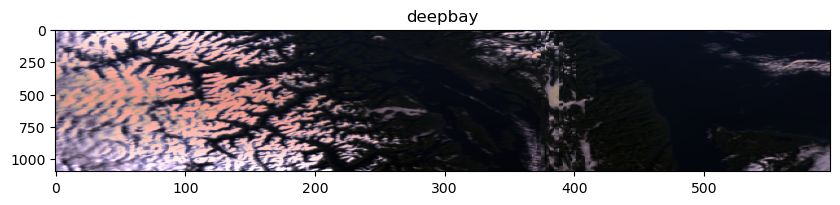

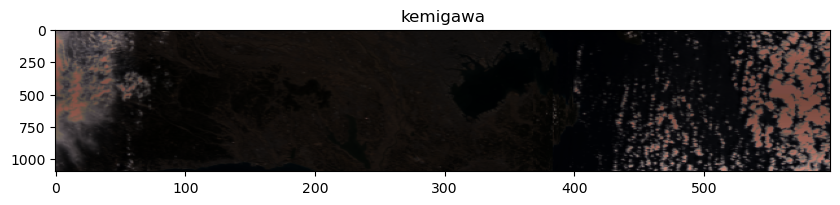

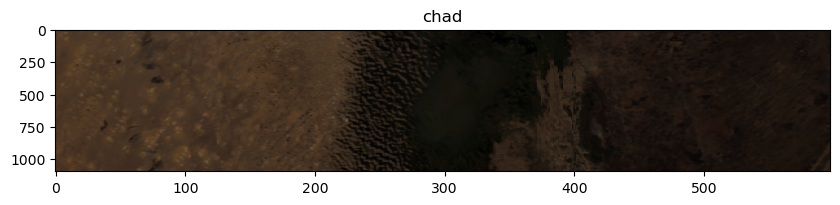

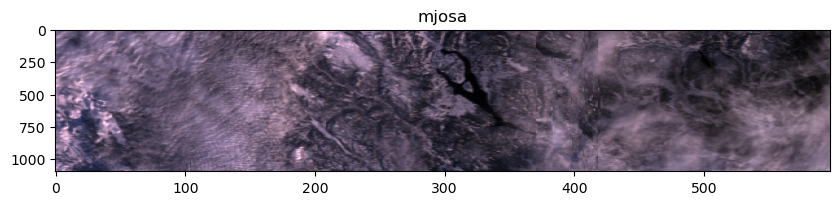

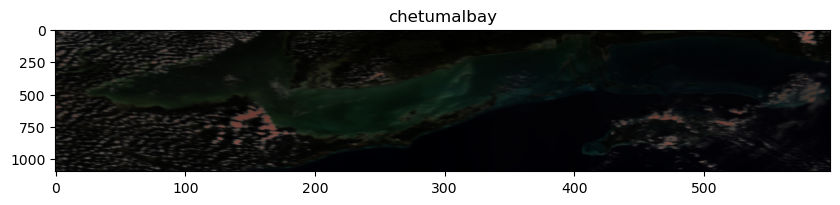

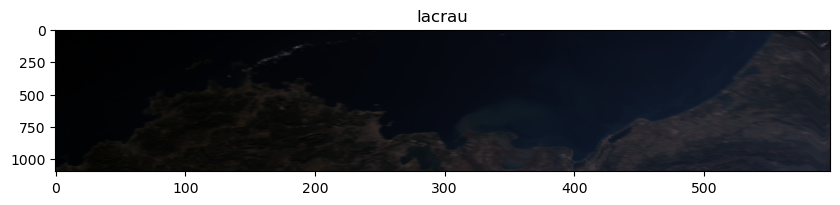

In [14]:
#Plot the rgb composite of the cm_norm arrays
rgb_grizzlybay = plot_cm_rgb_composite(grizzlybay_cm_norm, "grizzlybay")
rgb_victoriaLand = plot_cm_rgb_composite(victoriaLand_cm_norm, "victoriaLand")
rgb_catala = plot_cm_rgb_composite(catala_cm_norm, "catala")
rgb_menindee = plot_cm_rgb_composite(menindee_cm_norm, "menindee")
rgb_deepbay = plot_cm_rgb_composite(deepbay_cm_norm, "deepbay")
rgb_kemigawa = plot_cm_rgb_composite(kemigawa_cm_norm, "kemigawa")
rgb_chad = plot_cm_rgb_composite(chad_cm_norm, "chad")
rgb_mjosa = plot_cm_rgb_composite(mjosa_cm_norm, "mjosa")
rgb_chetumalbay = plot_cm_rgb_composite(chetumalbay_cm_norm, "chetumalbay")
rgb_lacrau = plot_cm_rgb_composite(lacrau_cm_norm, "lacrau")